# Combine N2O concentration estimates

Purpose: Combine methane atmospheric concentration estimates from Julian years 1-2017, from references at the end of this notebook, and do a logistic fit to the year 200-1749 estimates

Clear all variables and reset the working directory and import necessary libraries

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
os.chdir('C:\\Users\\cd7\\Desktop\\Heat17N2O')

Read two input files separately and assign the year values and nitride dioxide concentration data

In [2]:
df1 = pd.read_excel('cage17lawdome1-2004nov02_ud.xlsx')
df1.to_csv('cage17lawdome1-2004nov02_ud.csv',header=False,index=False)
df1 = pd.read_csv('cage17lawdome1-2004nov02_ud.csv')
df1.drop(df1.index[[-1]],inplace=True)
df1.drop(df1.columns[5], axis=1,inplace=True)

df2 = pd.read_excel('NOAA_MoleFractions_2016_ud.xlsx')
df2.to_csv('NOAA_MoleFractions_2016_ud.csv',header=False,index=False)
df2 = pd.read_csv('NOAA_MoleFractions_2016_ud.csv')
df2.drop(df2.index[[-1]],inplace=True)

Prepare for the nomenclature for the output excel sheet

In [3]:
out1 = 'heat'
out2 = 'n2o-1-2017'
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] # abbreviations for months to insert in output file name
date = datetime.date.today().strftime("%Y-%m-%d")
date_split = date.split('-') # split the date string we create by symbol "-"
yrs = str(int(date_split[0])-2000) # real years minus 2000
seq = [out1, yrs, out2,months[int(date_split[1])-1],date_split[2]]
seperator = ','
filename = seperator.join(seq).replace(',', '')

Combine N2O concentration estimates, after rescaling Law Dome to NOAA

In [4]:
yrslaw = df1.iloc[:,0:1]
newyrslaw = yrslaw['YearAD'].tolist()
newyrslaw = list(map(float, newyrslaw))
n2olaw =  df1.iloc[:,4:5]
df1 = pd.merge(yrslaw,n2olaw, left_index =True, right_index =True,how='outer')
df1 = df1.astype(float)
yrsnoaa = df2.iloc[:,0:1]
yrsnoaa = yrsnoaa['Year'].tolist()
yrsnoaa = list(map(float, yrsnoaa))
newyrsnoaa = [x -0.5 for x in yrsnoaa]
yrsnoaa = list(map(str, newyrsnoaa))
yrsnoaa = pd.DataFrame({'Year':yrsnoaa})
noaa = len(yrsnoaa)
n2onoaa = df2.iloc[:,3:4]
df2 = pd.merge(yrsnoaa,n2onoaa, left_index =True, right_index =True,how='outer')
df2 = df2.astype(float)
c1 = newyrsnoaa
c2 = newyrslaw
yrsboth = list(set(c1) & set(c2))
a = yrsboth[0]
b = yrsboth[-1]
n2olawboth = n2olaw[newyrslaw.index(a):newyrslaw.index(b)+1]
n2onoaaboth = n2onoaa[0:len(yrsboth)]
n2onoaaboth = n2onoaaboth['N2O'].tolist()
n2onoaaboth = list(map(float, n2onoaaboth))
n2olawboth = n2olawboth['N2Ospl'].tolist()
n2olawboth = list(map(float, n2olawboth))
rescalelaw = n2onoaaboth[0]/n2olawboth[0] # rescale the data of Law Dome to NOAA
yrs = list(range(1, 2018))
n2olaw = n2olaw.astype(float)
n2olaw *= float(rescalelaw)
n2olaw.drop(n2olaw.index[-int((1+newyrslaw[-1]-newyrsnoaa[0])):-1],inplace=True,axis=0) 
n2olaw = n2olaw[:-1]
n2olaw = n2olaw['N2Ospl'].tolist()
n2olaw = list(map(float, n2olaw))
n2onoaa = n2onoaa['N2O'].tolist()
n2onoaa = list(map(float, n2onoaa))
last = n2onoaa[-1] + 0.9 # 
# last = n2onoaa[-1] #
last = [float(last)]
n2o = n2olaw + n2onoaa + last
# print (n2o)
n2opre = n2o[yrs.index(200):yrs.index(1749)+1]
yrspre = range(200,1750)
# print(rescalelaw)

Define the fitted logistic function and fit data

In [5]:
def logistic(yrspre,c0,c1,c2,c3):
     y = c1 / (1 + np.exp(-(yrspre-c2)/c3))+c0
     return y
param_bounds=([200,0,700,0],[300,10,800,10])
popt,pcov = curve_fit(logistic, yrspre, n2opre, bounds=param_bounds)
print (popt)
print (popt[0]+popt[1])

[262.15046478   5.14085694 735.90876299   7.27679809]
267.2913217292295


Plot the fitted logistic function,comparing with the historical data and save the results as a csv file.

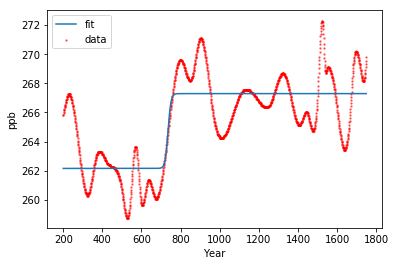

In [6]:
x = np.array(yrspre)
y = logistic(x, *popt)
plt.plot(x,y, label="fit")
plt.xlabel('Year')
plt.ylabel('ppb') 
plt.scatter(yrspre,n2opre,s=2,color = 'r', alpha = 0.5,label ='data',marker='o')
plt.legend(loc='best')
plt.savefig('n2o1.eps',dpi=1000)
plt.show()

yrs = list(map(str, yrs))
yrs = pd.DataFrame({'Year':yrs})
n2o = list(map(str, n2o))
n2o = pd.DataFrame({'N2O':n2o})
df = pd.merge(yrs, n2o, left_index =True, right_index =True,how='outer')
df.loc[-1]=['Julian','ppb']
df.index = df.index+1
df = df.sort_index()
df.loc[(len(df))] = ['2017/12/16','heat17n2odec16.nb']
df.to_csv(filename + '.csv', index=False)